TODO:

- Show mean (entire time series)
- Show standard deviation (entire time series)
- Show only one grid point
- Show at which instant is the multimodality
- 

In [29]:
import cartopy.crs as ccrs
import cartopy
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.widgets import Slider 

import sys
import os
from os import listdir, makedirs
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

sys.path.append("/home/natacha/Documents/Work/python")  # to import galib
sys.path.insert(1, os.path.join(sys.path[0], '..'))  #to use DataAnalysis submodules

from galib.tools.nc import print_nc_dict

##### What the NetCDF file looks like 

In [3]:
nc = Dataset("/home/natacha/Documents/Work/Data/Bergen/ec.ens.2020012900.sfc.meteogram.nc","r")

print_nc_dict(nc)

========= VARIABLE:  longitude  =========
shape:  (21,)
Key: units               |  Value: degrees_east
Key: long_name           |  Value: longitude
========= VARIABLE:  latitude  =========
shape:  (21,)
Key: units               |  Value: degrees_north
Key: long_name           |  Value: latitude
========= VARIABLE:  number  =========
shape:  (50,)
Key: long_name           |  Value: ensemble_member
========= VARIABLE:  time  =========
shape:  (51,)
Key: units               |  Value: hours since 1900-01-01 00:00:00.0
Key: long_name           |  Value: time
Key: calendar            |  Value: gregorian
========= VARIABLE:  msl  =========
shape:  (51, 50, 21, 21)
Key: scale_factor        |  Value: 0.17819648116216258
Key: add_offset          |  Value: 98593.53590175942
Key: _FillValue          |  Value: -32767
Key: missing_value       |  Value: -32767
Key: units               |  Value: Pa
Key: long_name           |  Value: Mean sea level pressure
Key: standard_name       |  Value: air_press

###### Where are situated the data

In [4]:
lon = np.array(nc.variables["longitude"])
lat = np.array(nc.variables["latitude"])

print("Longitude", lon)
print("Latitude", lat)

Longitude [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]
Latitude [70. 69. 68. 67. 66. 65. 64. 63. 62. 61. 60. 59. 58. 57. 56. 55. 54. 53.
 52. 51. 50.]


Lon Min:  -10.0  Lon Max:  10.0 Interval:  1.0
Lat Min:  70.0  Lat Max:  50.0 Interval:  1.0


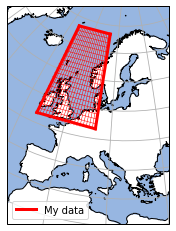

In [5]:
lon_0 = lon[0]
lon_1 = lon[-1]
lon_int = abs(lon[1] - lon[0])
lat_0 = lat[0]
lat_1 = lat[-1]
lat_int = abs(lat[1] - lat[0])


print("Lon Min: ", np.amin(lon), " Lon Max: ", np.amax(lon), "Interval: ", lon_int)
print("Lat Min: ", lat_0, " Lat Max: ", lat_1, "Interval: ", lat_int)

# Choose the center of the map to plot
central_lon, central_lat = 20, 50
# Choose the extent of the map
extent = [-10, 30, 30, 75]
# Choose the projection
nsp_trans = ccrs.NearsidePerspective()
# Used to transform coordinates
geodetic = ccrs.Geodetic()

# Transform our coordinates
lon_corner01, lat_corner01 = nsp_trans.transform_point(lon_0, lat_0, geodetic)
lon_corner02, lat_corner02 = nsp_trans.transform_point(lon_0, lat_1, geodetic)
lon_corner03, lat_corner03 = nsp_trans.transform_point(lon_1, lat_1, geodetic)
lon_corner04, lat_corner04 = nsp_trans.transform_point(lon_1, lat_0, geodetic)


# Draw the map
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(
    projection=ccrs.NearsidePerspective(
        central_longitude=central_lon,  
        central_latitude=central_lat,
    )
)
ax.set_extent(extent)


ax.add_feature(cartopy.feature.OCEAN) # Add oceans
ax.gridlines()                        # Add gridlines
ax.coastlines(resolution='50m')       # Add coastlines

show_grid = True

# Draw the lines
ax.plot([lon_corner01, lon_corner02], [lat_corner01, lat_corner02] , transform=nsp_trans, label="My data", c='r', lw=3)
ax.plot([lon_corner02, lon_corner03], [lat_corner02, lat_corner03] , transform=nsp_trans, c='r', lw=3)
ax.plot([lon_corner03, lon_corner04], [lat_corner03, lat_corner04] , transform=nsp_trans, c='r', lw=3)
ax.plot([lon_corner04, lon_corner01], [lat_corner04, lat_corner01] , transform=nsp_trans, c='r', lw=3)

if show_grid:
    for i in lon:
        # Transform our coordinates
        i_ad_lon, ad_lat = nsp_trans.transform_point(i, lat_1, geodetic)
        i_liv_lon, liv_lat = nsp_trans.transform_point(i, lat_0, geodetic)
        ax.plot([i_ad_lon, i_liv_lon], [ad_lat, liv_lat], transform=nsp_trans, c='r', lw=0.5)
    for i in lat:
        # Transform our coordinates
        ad_lon, i_ad_lat = nsp_trans.transform_point(lon_0, i, geodetic)
        liv_lon, i_liv_lat = nsp_trans.transform_point(lon_1, i, geodetic)
        ax.plot([ad_lon, liv_lon], [i_ad_lat, i_liv_lat] , transform=nsp_trans, c='r', lw=0.5)      


ax.legend()

#### Some statistics 

##### Mean

In [6]:
# Data to plot.
t2m = np.array(nc.variables["t2m"])
t2m -= 272.15 
time = np.array(nc.variables["time"])
time -= time[0]
number = np.array(nc.variables["number"])

print("Variable Temperature, shape: ", np.shape(t2m))

t = int(len(time)/2)
#print(t2m)

Variable Temperature, shape:  (51, 50, 21, 21)


In [7]:
mean_temp_t = np.mean(t2m[t], axis = 0)
mean_temp = np.mean(t2m, axis = (0,1))

print("Variable mean Temperature at instant", int(time[t]), "hours. Shape: ", np.shape(mean_temp_t))
print("Variable mean Temperature. Shape: ", np.shape(mean_temp))

Variable mean Temperature at instant 150 hours. Shape:  (21, 21)
Variable mean Temperature. Shape:  (21, 21)


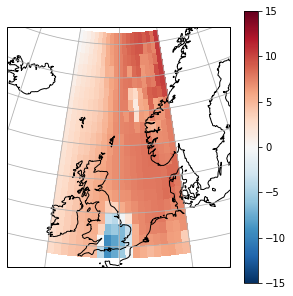

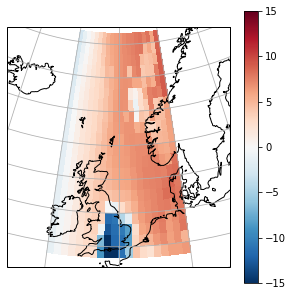

In [15]:
# Choose the center of the map to plot
central_lon, central_lat = 0, 60
# Choose the extent of the map
extent = [lon_0-5, lon_1+5, lat_0-2, lat_1]
extent = [-15, 15, 48, 70]
# Choose the projection
nsp_trans = ccrs.NearsidePerspective()
# Used to transform coordinates
geodetic = ccrs.Geodetic()

# Transform our coordinates
lon2d,lat2d = np.meshgrid(lon, lat)

trans_lon, trans_lat = np.zeros_like(lon2d), np.zeros_like(lat2d)
for i, lon_i in enumerate(lon):
#for i, lon_i in enumerate(np.flip(lon)):
    #for j, lat_j in enumerate(np.flip(lat)):
    for j, lat_j in enumerate(lat):
        trans_lon[i,j], trans_lat[i,j] = nsp_trans.transform_point(lon_i, lat_j, geodetic)


# Draw the maps
for i in range(2):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plt.axes(
        projection=ccrs.NearsidePerspective(
            central_longitude=central_lon,  
            central_latitude=central_lat,
        )
    )
    ax.set_extent(extent)

    #ax.add_feature(cartopy.feature.OCEAN) # Add oceans
    ax.gridlines()                        # Add gridlines
    ax.coastlines(resolution='50m')       # Add coastlines
    cmap = plt.get_cmap('RdBu_r')
    if i == 0:
        cf = ax.pcolormesh(
            trans_lon, trans_lat, mean_temp, 
            transform=nsp_trans, cmap=cmap, vmin=-15, vmax=15)
        fig.colorbar(cf, ax=ax)
    else: 
        cf = ax.pcolormesh(
            trans_lon, trans_lat, mean_temp_t, 
            transform=nsp_trans, cmap=cmap, vmin=-15, vmax=15)
        fig.colorbar(cf, ax=ax)
    plt.show()


##### Standard deviation

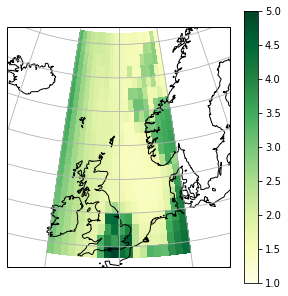

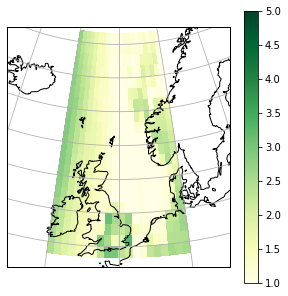

In [13]:
std_temp_t = np.std(t2m[t], axis = 0)
std_temp = np.std(t2m, axis = (0,1))

# Draw the map

# Draw the maps
for i in range(2):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plt.axes(
        projection=ccrs.NearsidePerspective(
            central_longitude=central_lon,  
            central_latitude=central_lat,
        )
    )
    ax.set_extent(extent)

    #ax.add_feature(cartopy.feature.OCEAN) # Add oceans
    ax.gridlines()                        # Add gridlines
    ax.coastlines(resolution='50m')       # Add coastlines
    cmap = plt.get_cmap('YlGn')
    if i == 0:
        cf = ax.pcolormesh(
            trans_lon, trans_lat, std_temp, 
            transform=nsp_trans, cmap=cmap, vmin=1, vmax=5)
        fig.colorbar(cf, ax=ax)
    else: 
        cf = ax.pcolormesh(
            trans_lon, trans_lat, std_temp_t, 
            transform=nsp_trans, cmap=cmap, vmin=1, vmax=5)
        fig.colorbar(cf, ax=ax)
    plt.show()

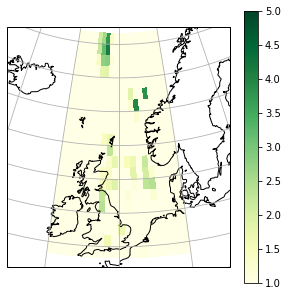

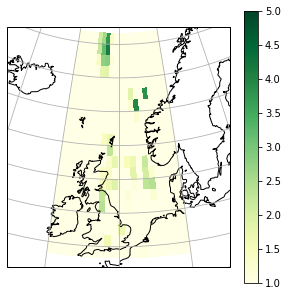

In [32]:
kurtosis_temp_t = kurtosis(t2m[t], axis = 0)
kurtosis_temp = kurtosis(t2m[t], axis = 0)

# Draw the map

# Draw the maps
for i in range(2):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plt.axes(
        projection=ccrs.NearsidePerspective(
            central_longitude=central_lon,  
            central_latitude=central_lat,
        )
    )
    ax.set_extent(extent)

    #ax.add_feature(cartopy.feature.OCEAN) # Add oceans
    ax.gridlines()                        # Add gridlines
    ax.coastlines(resolution='50m')       # Add coastlines
    cmap = plt.get_cmap('YlGn')
    if i == 0:
        cf = ax.pcolormesh(
            trans_lon, trans_lat, kurtosis_temp, 
            transform=nsp_trans, cmap=cmap, vmin=1, vmax=5)
        fig.colorbar(cf, ax=ax)
    else: 
        cf = ax.pcolormesh(
            trans_lon, trans_lat, kurtosis_temp_t, 
            transform=nsp_trans, cmap=cmap, vmin=1, vmax=5)
        fig.colorbar(cf, ax=ax)
    plt.show()

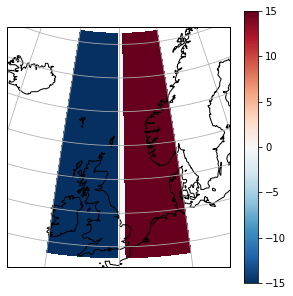

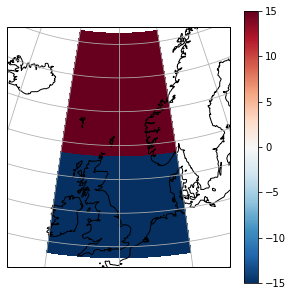

In [27]:
# Choose the center of the map to plot
central_lon, central_lat = 0, 60
# Choose the extent of the map
extent = [lon_0-5, lon_1+5, lat_0-2, lat_1]
extent = [-15, 15, 48, 70]
# Choose the projection
nsp_trans = ccrs.NearsidePerspective()
# Used to transform coordinates
geodetic = ccrs.Geodetic()

# Transform our coordinates
lon2d,lat2d = np.meshgrid(lon, lat)

trans_lon, trans_lat = np.zeros_like(lon2d), np.zeros_like(lat2d)
for i, lon_i in enumerate(lon):
#for i, lon_i in enumerate(np.flip(lon)):
    #for j, lat_j in enumerate(np.flip(lat)):
    for j, lat_j in enumerate(lat):
        trans_lon[i,j], trans_lat[i,j] = nsp_trans.transform_point(lon_i, lat_j, geodetic)


# Draw the maps
for i in range(2):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plt.axes(
        projection=ccrs.NearsidePerspective(
            central_longitude=central_lon,  
            central_latitude=central_lat,
        )
    )
    ax.set_extent(extent)

    #ax.add_feature(cartopy.feature.OCEAN) # Add oceans
    ax.gridlines()                        # Add gridlines
    ax.coastlines(resolution='50m')       # Add coastlines
    cmap = plt.get_cmap('RdBu_r')
    if i == 0:
        cf = ax.pcolormesh(
            trans_lon, trans_lat, trans_lon-np.mean(trans_lon), 
            transform=nsp_trans, cmap=cmap, vmin=-15, vmax=15)
        fig.colorbar(cf, ax=ax)
    else: 
        cf = ax.pcolormesh(
            trans_lon, trans_lat, trans_lat-np.mean(trans_lat), 
            transform=nsp_trans, cmap=cmap, vmin=-15, vmax=15)
        fig.colorbar(cf, ax=ax)
    plt.show()

In [9]:
t_min = 0    # the minimial value of the paramater a
t_max = len(time)-1   # the maximal value of the paramater a
t_init = int(len(time)/2)  # the value of the parameter a to be used initially, when the graph is created


fig, ax = plt.subplots(figsize=(8,3))

# first we create the general layount of the figure
# with two axes objects: one for the plot of the function
# and the other for the slider
slider_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03], axisbg=axis_color)
slider = Slider(amp_slider_ax, 'Time', t_min, t_max, valinit=t_init)

# in plot_ax we plot the function with the initial value of the parameter a
plt.axes(sin_ax) # select sin_ax
plt.title('y = sin(ax)')
sin_plot, = plt.plot(x, np.sin(a_init*x), 'r')
plt.xlim(0, 2*pi)
plt.ylim(-1.1, 1.1)

# here we create the slider
a_slider = Slider(slider_ax,      # the axes object containing the slider
                  'a',            # the name of the slider parameter
                  a_min,          # minimal value of the parameter
                  a_max,          # maximal value of the parameter
                  valinit=a_init  # initial value of the parameter
                 )

# Next we define a function that will be executed each time the value
# indicated by the slider changes. The variable of this function will
# be assigned the value of the slider.
def update(a):
    sin_plot.set_ydata(np.sin(a*x)) # set new y-coordinates of the plotted points
    fig.canvas.draw_idle()          # redraw the plot

# the final step is to specify that the slider needs to
# execute the above function when its value changes
a_slider.on_changed(update)

plt.show()

NameError: name 'axis_color' is not defined